## Using **Money Flow Index (MFI) ** to set trading strategy
* MFI is used to measure the inflows/outflows of money into/from an asset over time
* Usually calculated over a 14 day period for stocks
* Usually represented as a scale from 0 to 100
* If the MFI is over 80 it is thought that the market is showing over-bought conditions, and if it is showing below 20 then it is showing over-sold conditions 
* When these levels are met the market might change direction
* MFI is a leading indicator used to predict price movement <br>
Source:https://www.ig.com/uk/trading-strategies/what-is-the-money-flow-index-and-how-does-it-work--190618 

Source for code: https://www.youtube.com/watch?v=tF1Lz4WBQwM&t=26s&ab_channel=ComputerScience
<br>All currency figures are in Indian Rupees (INR)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
# Read the file in from device
date_cols = ['Date']
df = pd.read_csv('BTC_INR.csv', parse_dates=date_cols, infer_datetime_format=True, index_col=['Date'])

In [5]:
# Check the first few rows
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-24,531125.5625,534905.8750,528807.6250,532109.6250,532109.6250,1.155234e+12
2019-10-25,531911.8125,615708.6875,529882.0625,613524.0625,613524.0625,2.033467e+12
2019-10-26,614011.1875,709940.3750,613660.1875,654913.8125,654913.8125,3.152115e+12
2019-10-27,654682.5000,690656.6250,645532.4375,676643.4375,676643.4375,2.308897e+12
2019-10-28,677591.8125,693664.0625,654827.1250,654827.1250,654827.1250,2.189437e+12


In [7]:
# Checking for missing values
check = pd.isnull(df['Close'])
df[check]
# One day of missing values:

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# There is 1 day of missing values. Using linear interpolate to fill that value
df = df.interpolate()
# Missing values filled in using interpolate()
df[check]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-04,834176.75,872190.40625,831134.90625,861993.21875,861993.21875,1.674818e+12


### Visualise the data

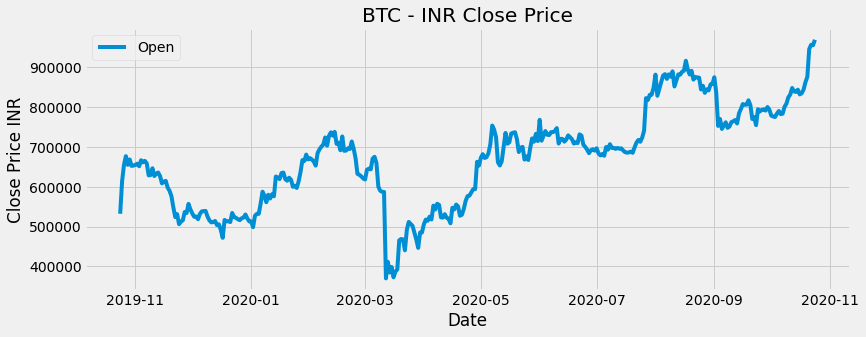

In [10]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['Close'], label = "Closing Price")
plt.title("BTC - INR Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price INR')
plt.legend(df.columns.values, loc='upper left')
plt.show()

Calculate typical price

In [11]:
typical_price = (df['Close'] + df['High'] + df['Low'])/3

Set the period

In [12]:
period = 14

Calculate the money flow

In [13]:
money_flow = typical_price * df['Volume']

Get all the positive and negative money flows

In [14]:
positive_flow = []
negative_flow = []

for i in range(1, len(typical_price)): # Loop starting from the 2nd typical_price to the end
    if typical_price[i] > typical_price[i-1]: # Check if current typical price is greater than yesterday's typical price
        positive_flow.append(money_flow[i-1]) # Append the money flow of previous typical price to positive flow
        negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]: # Check if current typical price is less than yesterday's typical price
        negative_flow.append(money_flow[i-1]) # Append the money flow of previous typical price to negative flow
        positive_flow.append(0)
    else:
        positive_flow.append(0)
        negative_flow.append(0)

Get the positive and negative money flows within the time period

In [15]:
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i + 1-period : i+1])) # Sum of the pos_flows for 13 days rolling 
for i in range(period-1, len(negative_flow)):
    negative_mf.append(sum(negative_flow[i + 1-period : i+1]))

Calculate the MFI

In [16]:
mfi = 100 * np.array(positive_mf)/(np.array(positive_mf) + np.array(negative_mf))

## Visualise the MFI

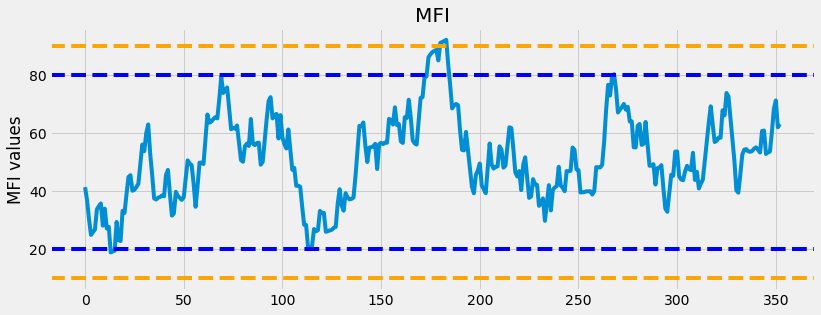

In [17]:
df2 = pd.DataFrame()
df2['MFI'] = mfi
plt.figure(figsize=(12.2, 4.5))
plt.plot(df2['MFI'], label = "MFI")
plt.axhline(10, linestyle= '--', color='orange')
plt.axhline(20, linestyle= '--', color='blue')
plt.axhline(80, linestyle= '--', color='blue')
plt.axhline(90, linestyle= '--', color='orange')
plt.title("MFI")
plt.ylabel('MFI values')
plt.show()

In [22]:
# New Data Frame
new_df = pd.DataFrame()
new_df = df.iloc[period:,:]
new_df['MFI'] = mfi
new_df.head()

,Open,High,Low,Close,Adj Close,Volume,MFI
Date,,,,,,,
2019-11-07,664113.4375,665602.1250,653799.5625,658432.4375,658432.4375,1.612794e+12,41.460001
2019-11-08,658276.6250,661861.7500,626371.3125,628466.0000,628466.0000,1.736819e+12,36.970336
2019-11-09,628793.5000,634671.3125,627629.6250,629087.0625,629087.0625,1.254710e+12,30.424600
2019-11-10,629009.0625,649746.3125,628501.8750,646299.1250,646299.1250,1.469374e+12,24.981530
2019-11-11,646398.4375,649933.5625,622689.5000,626781.8125,626781.8125,1.450372e+12,25.937201


In [23]:
# function to get the buy and sell signals
def get_signal(data, high, low):
    ''' The 'high' and 'low' parameters tell us if the asset is 
        over-bought or over-sold'''

    buy_signal = []
    sell_signal = []

    for i in range(len(data['MFI'])): # Loop through the dataset
        if data['MFI'][i] >= high: # If the MFI value is higher than the 'high' -> sell signal
            sell_signal.append(data['Close'][i]) # append the 'close' position to sell signal list
            buy_signal.append(np.nan)
        elif data['MFI'][i] <= low: # If the MFI value is lower than the 'low' -> buy signal
            buy_signal.append(data['Close'][i]) # append the 'close' position to sell signal list
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)

    return (buy_signal, sell_signal)

In [24]:
# Add 2 new columns to the new dataframe with the buy and sell signals
new_df['Buy'] = get_signal(new_df, 80, 20)[0] # Takes the 1st value from the tuple of the func and assigns it to the 'Buy' column
new_df['Sell'] = get_signal(new_df, 80, 20)[1] # Takes the 2nd value from the tuple of the func and assigns it to the 'Sell' column

Plot the data

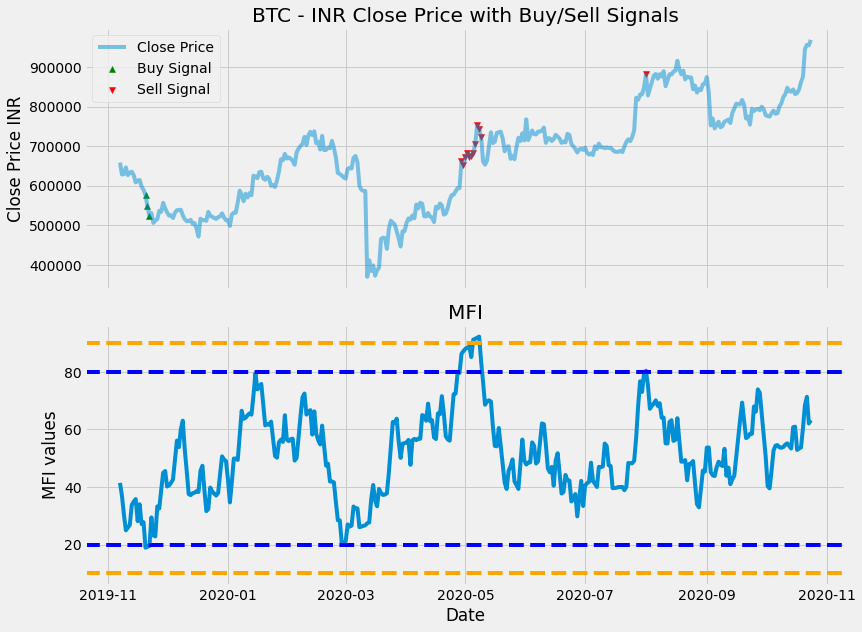

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12.2, 9))

ax1.plot(new_df['Close'], label = "Close Price", alpha=0.5)
ax1.scatter(new_df.index, new_df['Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
ax1.scatter(new_df.index, new_df['Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
ax1.set_title("BTC - INR Close Price with Buy/Sell Signals")
ax1.set_ylabel('Close Price INR')
ax1.legend(loc='upper left')

ax2.plot(new_df['MFI'], label = "MFI")
ax2.axhline(10, linestyle= '--', color='orange')
ax2.axhline(20, linestyle= '--', color='blue')
ax2.axhline(80, linestyle= '--', color='blue')
ax2.axhline(90, linestyle= '--', color='orange')
ax2.set_title("MFI")
ax2.set_ylabel('MFI values')
ax2.set_xlabel('Date')

plt.tight_layout()
plt.show()

In [26]:
buy_signal_entries = new_df[new_df.Buy.notna()].copy()
buy_signal_entries

,Open,High,Low,Close,Adj Close,Volume,MFI,Buy,Sell
Date,,,,,,,,,
2019-11-20,589519.8125,591254.250,574980.1250,576182.87500,576182.87500,1.490424e+12,18.943348,576182.87500,NaN
2019-11-21,575922.7500,581903.625,545115.9375,548371.12500,548371.12500,1.615408e+12,19.283462,548371.12500,NaN
2019-11-22,548429.9375,552615.125,498004.1875,523840.28125,523840.28125,2.458345e+12,19.532845,523840.28125,NaN


In [28]:
sell_signal_entries = new_df[new_df.Sell.notna()].copy()
sell_signal_entries

,Open,High,Low,Close,Adj Close,Volume,MFI,Buy,Sell
Date,,,,,,,,,
2020-04-29,593869.8750,667758.2500,591778.6875,662441.8125,662441.8125,4.531249e+12,86.254572,NaN,662441.8125
2020-04-30,662188.3125,707954.4375,643129.3125,652947.5625,652947.5625,5.049849e+12,87.251592,NaN,652947.5625
2020-05-01,654020.5000,684844.9375,653642.0000,672472.3750,672472.3750,3.342984e+12,88.027580,NaN,672472.3750
2020-05-02,672797.8125,683024.0625,664460.7500,681614.2500,681614.2500,3.043431e+12,88.455498,NaN,681614.2500
2020-05-03,681236.4375,691337.8125,667630.2500,672054.6875,672054.6875,3.557751e+12,88.767328,NaN,672054.6875
2020-05-04,671924.5000,677503.1250,654676.8750,674153.1875,674153.1875,3.458170e+12,85.150228,NaN,674153.1875
2020-05-05,674166.5625,684506.8125,670900.3125,683718.3750,683718.3750,3.276815e+12,91.210303,NaN,683718.3750
2020-05-06,684050.3125,717596.6875,680948.6875,706511.8750,706511.8750,3.763375e+12,91.489800,NaN,706511.8750
2020-05-07,705988.4375,756565.5625,695609.1250,753450.3750,753450.3750,4.626971e+12,91.855213,NaN,753450.3750


In [42]:
def get_buy_sell_pairs(buys_df, sells_df):
    ''' Takes a buy dataframe (buys_df) & and sell dataframe (sells_df)
        and returns buy/sell pairs such that the buy date is before the 
        sell date.    
    '''
    pairs = []
    date_set = set()

    for buy_date, buy_row in buys_df.iterrows():
        for sell_date, sell_row in sells_df.iterrows():
            if (buy_date.date() not in date_set) and (sell_date.date() not in date_set) and (buy_date.date() < sell_date.date()):
                pairs.append((buy_row['Buy'], sell_row['Sell']))
                date_set.add(buy_date.date())
                date_set.add(sell_date.date())
    return pairs

In [43]:
buy_sell_pairs = get_buy_sell_pairs(buy_signal_entries, sell_signal_entries)
buy_sell_pairs

[(576182.875, 662441.8125),
 (548371.125, 652947.5625),
 (523840.28125, 672472.375)]

In [30]:
def get_trade_value(buy_price, sell_price, stake):
    ''' Calculates the profit/loss of a sale given 
        the purchase price of an asset (buy_price), 
        the sales price of the asset (sell_price) &
        and the amount invested in the asset'''
    BTC_one_INR = 1/buy_price
    amount_purchased = BTC_one_INR * stake
    sales_value = amount_purchased * sell_price
    return round(sales_value - stake,2)

In [44]:
# Get the profit/loss of executing the buy-sell for 
stake_bid = 10000 
sale_values = [get_trade_value(b,s,stake_bid) for b,s in buy_sell_pairs]
sale_values

[1497.08, 1907.04, 2837.36]

In [46]:
print(f'We would have made INR {np.sum(sale_values)} by following MFI strategy and staking INR {stake_bid} each on {len(sale_values)} trades over a period of a {(df.index[-1]-df.index[0]).days} days.\nThis would have yielded a ROI of {round(np.sum(sale_values)/(stake_bid* len(sale_values))*100,2)}%.\nThis does not take into account exchange fees')

We would have made INR 6241.48 by following MFI strategy and staking INR 10000 each on 3 trades over a period of a 366 days.
This would have yielded a ROI of 20.8%.
This does not take into account exchange fees
